In [9]:
import numpy as np
import sympy as sp

from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.integrate import quad

from matplotlib import pylab as pl
import matplotlib
matplotlib.rc('font', **{'size':16})

Parameters:

In [10]:
MPBH = 30.0
rtr = 0.0063*(MPBH**(1.0/3.0))
G = 4.302e-3 #Units of (pc/solar mass) (km/s)^2
A = 3.0*MPBH/(8*np.pi*rtr**3)
B = G*MPBH/rtr

**DM Density profile:**

In [11]:
def rho_inner(x):
    return A*x**(-3.0/2.0)

def rho_outer(x):
    return A*sp.exp(-(x-1)*10.0)

def rho_scalar(x):
    if (x < 0):
        return 0
    if (x <= 1):
        return rho_inner(x)
    elif (x > 1):
        return rho_outer(x)

rho = np.vectorize(rho_scalar)
    

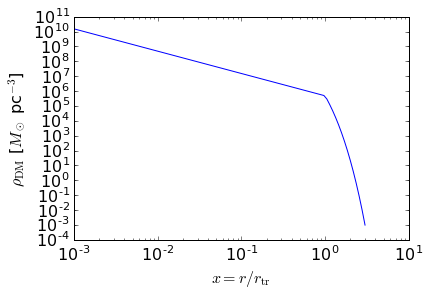

In [12]:
#Check the density
pl.figure()
xlist = np.logspace(-3, np.log10(3),100)
pl.loglog(xlist, rho(xlist))
pl.xlabel(r"$x = r/r_\mathrm{tr}$")
pl.ylabel(r"$\rho_\mathrm{DM}$ [$M_\odot$ pc$^{-3}$]")
pl.show()

**Potentials:**

In [26]:
#Mass enclosed
def M_inner(x):
    return MPBH*(1+x**(3.0/2.0))

x1 = sp.symbols('x1')
def M_outer(x):
    return 2*MPBH + rtr**3*4*np.pi*sp.integrate(rho_outer(x1)*x1**2, (x1, 1, x))

def Menc(x):
    if (x < 1):
        return M_inner(x)
    elif (x >= 1):
        return M_outer(x)


    
y = sp.symbols('y')
psi_outer_func = (G/rtr)*sp.integrate(M_outer(x1)/x1**2, (x1, y, np.inf))

def psi_outer(xin):
    return psi_outer_func.subs(y,xin)
#Potential at the truncation radius
psi_tr = float(psi_outer(1))



def psi_inner(x):
    return psi_tr + B*(1 + x**-1 - 2.0*x**0.5)

psi_min = float(psi_outer(10))
psi_max = float(psi_inner(1e-5))

def psi_scalar(x):
    if (x < 1):
        return psi_inner(x)
    elif (x >=1):
        return float(psi_outer(x))
    
psi = np.vectorize(psi_scalar)

Potential at x = 5: 1.4392329573
Potential at x = 1: 14.273657135
Potential at x = 1e-5: 659312.147504
Fraction of particles inside x = 1e-2: 0.000845308537616162


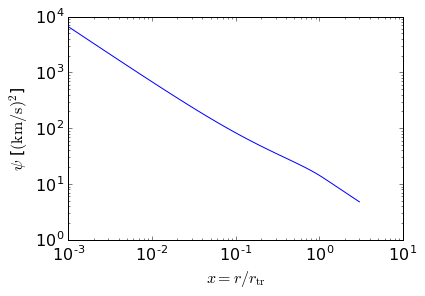

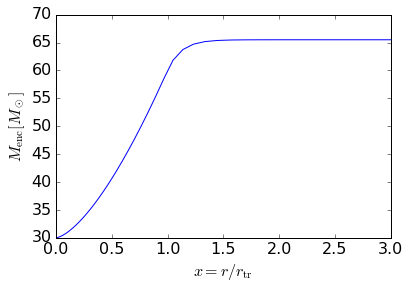

In [28]:
#Check the potential
print "Potential at x = 5:", psi_min
print "Potential at x = 1:", psi_tr
print "Potential at x = 1e-5:", psi_max

print "Fraction of particles inside x = 1e-2:", (Menc(1e-2)-30)/(Menc(100)-30)

pl.figure()
xlist = np.logspace(-3, np.log10(3),100)
pl.loglog(xlist, psi(xlist))
pl.xlabel(r"$x = r/r_\mathrm{tr}$")
pl.ylabel(r"$\psi$ [$(\mathrm{km}/\mathrm{s})^2$]")
pl.show()

pl.figure()
xlist = np.logspace(-3, np.log10(3),100)
pl.plot(xlist, np.vectorize(Menc)(xlist))
pl.xlabel(r"$x = r/r_\mathrm{tr}$")
pl.ylabel(r"$M_\mathrm{enc} [M_\odot]$")
pl.show()

**Calculating density as a function of potential:**

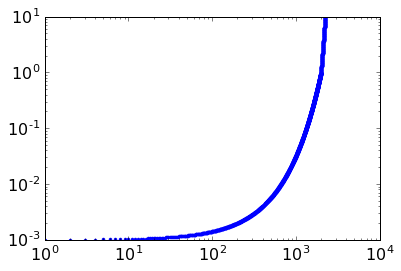

In [627]:
xlist = np.logspace(-3, np.log10(1),2000)
xlist = np.append(xlist,np.logspace(np.log10(1.01), 1, 250))
pl.figure()
pl.loglog(xlist, '.')
pl.show()

In [628]:
rholist = rho(xlist)
psilist = np.asarray(psi(xlist),dtype='float64')
rholist = np.append(rholist, 0)
psilist = np.append(psilist, 0)

In [629]:
rho_of_psi = UnivariateSpline(psilist[::-1],rholist[::-1])

In [630]:
d2rho = rho_of_psi.derivative(n=2)

In [631]:
d2rho(10)

array(10404.187493140744)

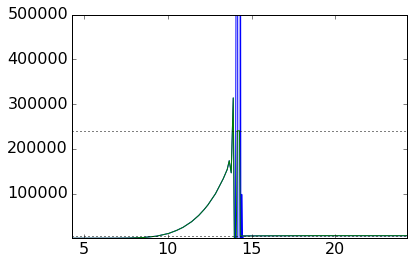

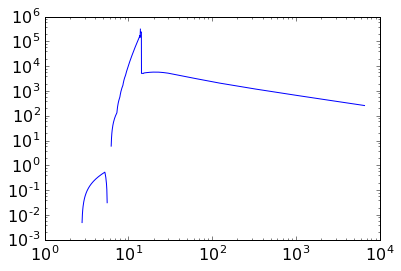

In [632]:
pl.figure()
pl.plot(psilist,d2rho(psilist))
pl.plot(psilist,np.vectorize(d2rho_fixed)(psilist))
#pl.xlim(0, psi_tr)
pl.xlim(psi_tr-10.0, psi_tr +10.0)
pl.ylim(1e3, 500000)
pl.axhline(240244.0,linestyle=':', color='k')
pl.axhline(5148.09,linestyle=':', color='k')
pl.show()

pl.figure()
pl.loglog(psilist,np.vectorize(d2rho_fixed)(psilist))
#pl.xlim(0, psi_tr)
pl.show()

**Calculating the jump**

In [633]:
deriv_inner = (sp.diff(rho_inner(x1),x1)/sp.diff(psi_inner(x1),x1)).subs(x1, 1.0)
deriv_outer = (sp.diff(rho_outer(x1),x1)/sp.diff(psi_outer(x1),x1)).subs(x1, 1.0)
jump = deriv_inner - deriv_outer
print jump

-307731.048792673


In [634]:
#Value of d2rho either side of the jump
rho_p = sp.diff(rho_inner(x1),x1).subs(x1, 1.0)
rho_pp = sp.diff(rho_inner(x1),x1,2).subs(x1, 1.0)
psi_p = sp.diff(psi_inner(x1),x1).subs(x1, 1.0)
psi_pp = sp.diff(psi_inner(x1),x1,2).subs(x1, 1.0)

print ((rho_pp/psi_p**2) - rho_p*psi_pp/(psi_p**3))

#Value of d2rho either side of the jump
rho_p = sp.diff(rho_outer(x1),x1).subs(x1, 1.0)
rho_pp = sp.diff(rho_outer(x1),x1,2).subs(x1, 1.0)
psi_p = sp.diff(psi_outer(x1),x1).subs(x1, 1.0)
psi_pp = sp.diff(psi_outer(x1),x1,2).subs(x1, 1.0)

print ((rho_pp/psi_p**2) - rho_p*psi_pp/(psi_p**3))

5148.09210043307
240244.298020210


In [635]:
def d2rho_fixed(psi):
    if (psi_tr - 0.25 < psi <= psi_tr):
        return 240244.0
    elif (psi_tr < psi <= psi_tr +1.0):
        return 5148.09
    else:
        return d2rho(psi)

In [661]:
def calcf1(eps):
    integ = lambda p: d2rho(p)/np.sqrt(eps - p)
    return quad(integ, 0, eps)[0]/(np.sqrt(8)*np.pi**2)

In [662]:
e_list = np.logspace(np.log10(psi_min), np.log10(psi_max),1000)

In [663]:
fvals = 0.0*e_list
for i in tqdm(range(len(e_list))):
    fvals[i] = calcf1(e_list[i])
e_list = np.append(0.0, e_list)
fvals = np.append(0.0, fvals)

100%|██████████| 1000/1000 [00:30<00:00, 28.03it/s]


In [5]:
e_list, fvals = np.loadtxt("distribution_exp.dat", unpack=True)

In [6]:
finterp = UnivariateSpline(e_list, fvals)

In [20]:
def stepfun(E):
    if (E < psi_tr):
        return 0
    else:
        return 0
    #    return (1.0/(np.sqrt(8.0)*np.pi**2))*float(jump)/np.sqrt(E - psi_tr)

def f(eps):
    step = 0.0
    #if (eps > psi_tr):
    #    step = stepfun(eps)
    return finterp(eps) + 0.0*step

f_vec = np.vectorize(f)

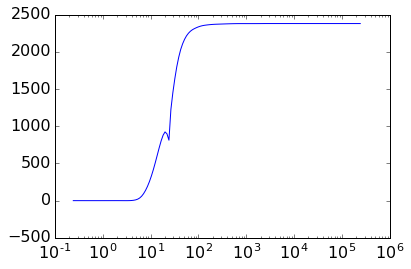

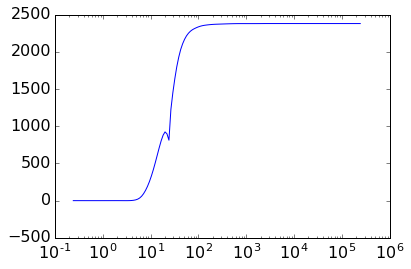

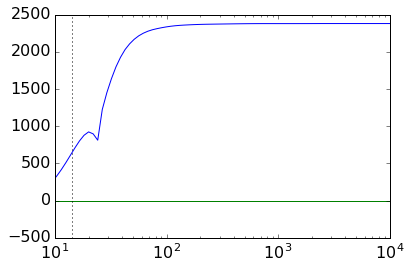

In [21]:
pl.figure()
pl.semilogx(e_list,f_vec(e_list))
pl.semilogx(e_list,np.vectorize(stepfun)(e_list))
pl.axvline(psi_tr, linestyle=':', color='k')
#pl.ylim(-1000, 100000)
pl.xlim(10, 10000)
pl.show()

**Re-checking the density:**

In [22]:
def vmax(x):
    return np.sqrt(2*float(psi(x)))

def dens(x):
    integ = lambda v: v**2*f(psi(x) - 0.5*v**2)
    return 4*np.pi*quad(integ, 0, vmax(x))[0]

In [23]:
print rho(0.5)
print dens(0.5)
psi(1e-3)

1350220.63276
506825.814594


array(6613.362824224058)

In [24]:
xlist2 = np.logspace(-3, np.log10(2),50)
dens_list = 0.0*xlist2
for i in tqdm(range(len(xlist2))):
    dens_list[i] = dens(xlist2[i])

100%|██████████| 50/50 [00:03<00:00,  9.55it/s]


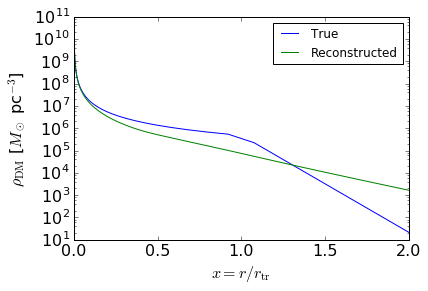

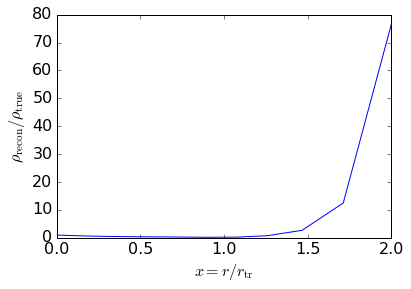

In [25]:
pl.figure()
pl.semilogy(xlist2, rho(xlist2), label="True")
pl.semilogy(xlist2, dens_list, label="Reconstructed")
pl.legend(loc='best',fontsize=12.0)
pl.xlabel(r'$x = r/r_\mathrm{tr}$')
pl.ylabel(r"$\rho_\mathrm{DM}$ [$M_\odot$ pc$^{-3}$]")

pl.figure()
pl.plot(xlist2, dens_list/rho(xlist2))
pl.xlabel(r'$x = r/r_\mathrm{tr}$')
pl.ylabel(r"$\rho_\mathrm{recon}/\rho_\mathrm{true}$")
pl.show()